In [3]:
#init libs
import math
import csv
import numpy as np
from numpy import loadtxt
from tensorflow.python.keras import Input, Model, Sequential
from tensorflow.python.keras.layers import  Concatenate, Activation, Dropout,Conv1D,MaxPooling1D,  Flatten, Dense, LSTM, Reshape, Permute,BatchNormalization
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.models import model_from_json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(np.__version__)

1.18.1


In [2]:
#open processed datasets
csv_train=open('processed_data/train_dataset.txt', newline='')
reader_train = csv.reader(csv_train, delimiter=',', quotechar='|')

csv_test=open('processed_data/test_dataset.txt', newline='')
reader_test = csv.reader(csv_test, delimiter=',', quotechar='|')

X_train_dataset=[]
X_test_dataset=[]

Y_train_dataset=[]
Y_test_dataset=[]

In [3]:
#control variables for input of neural network


target_size=10      #num of position for elements in formula
num_elements=17      # paramertrs of one element (1 coefficeent of element in formula, 16 parametrs of element from chemestry table)


#you can change target_size, but num_elements must have value 17 for these processed data. 
# if you want train network with different parametrs, you must change variable "params_order" in file preparecsvBIG.ipynb and create your won dataset from source data 

In [4]:
#preprocessing datasets
train_num_fromulas=0
test_num_fromulas=0
counter_tr=0    
read_it=True
while(read_it==True):
    try:
        counter_tr=counter_tr+1
        read_row = next(reader_train)
        crit_temp=read_row[-1]
        Y_train_dataset.append(float(crit_temp))
    
        buf=[]
        for i in range(len(read_row)-1):
            c=read_row[i].split(" ")
            for j in range(len(c)):
                c[j]=float(c[j])
            c=np.asarray(c)
            buf.append(c)
        buf=np.asarray(buf)
        X_train_dataset.append(buf)
        train_num_fromulas=train_num_fromulas+1
    except StopIteration:
        read_it=False
csv_train.close() 

counter_ts=0
read_it=True
while(read_it==True):
    try:
        counter_ts=counter_ts+1
        read_row = next(reader_test)
        crit_temp=read_row[-1]
        Y_test_dataset.append(float(crit_temp))
    
        buf=[]
        for i in range(len(read_row)-1):
            c=read_row[i].split(" ")
            for j in range(len(c)):
                c[j]=float(c[j])
            c=np.asarray(c)
            buf.append(c)
        buf=np.asarray(buf)
        X_test_dataset.append(buf)
        test_num_fromulas=test_num_fromulas+1
    except StopIteration:
        read_it=False
csv_test.close() 


X_test_dataset=np.asarray(X_test_dataset)
X_train_dataset=np.asarray(X_train_dataset)

add_arr=[]
for i in range(num_elements):
    add_arr.append(0)
add_arr=np.asarray(add_arr)

X_test_dataset_processed=[]
Y_test_dataset_processed=[]

X_val_dataset_processed=[]
Y_val_dataset_processed=[]

X_train_dataset_processed=[]
Y_train_dataset_processed=[]


for i in range(X_test_dataset.shape[0]):

    c=X_test_dataset[i].shape[0]
    dist=target_size-X_test_dataset[i].shape[0]
    buf1=[]
    
    if dist>0:
        for j in range(dist):
            buf1.append(add_arr)
    for j in range(X_test_dataset[i].shape[0]):
        buf1.append(X_test_dataset[i][j])
    buf1=np.asarray(buf1)
    X_test_dataset_processed.append(buf1)
    Y_test_dataset_processed.append(Y_test_dataset[i])

for i in range(X_train_dataset.shape[0]):

    c=X_train_dataset[i].shape[0]
    dist=target_size-X_train_dataset[i].shape[0]
    buf1=[]
    
    if dist>0:
        for j in range(dist):
            buf1.append(add_arr)
    for j in range(X_train_dataset[i].shape[0]):
        buf1.append(X_train_dataset[i][j])
    buf1=np.asarray(buf1)
    X_train_dataset_processed.append(buf1)
    Y_train_dataset_processed.append(Y_train_dataset[i])


X_test_dataset_processed=np.asarray(X_test_dataset_processed)
X_train_dataset_processed=np.asarray(X_train_dataset_processed)

In [5]:
#download network C2
model2j="/content/gdrive/My Drive/superconductor/171_mse_conv1_perm_k3_p2.json"
model2h="/content/gdrive/My Drive/superconductor/171_mse_conv1_perm_k3_p2.h5"

json_file = open(model2j, "r")
loaded_model_json = json_file.read()
json_file.close()

model1 = model_from_json(loaded_model_json)
model1.load_weights(model2h)
model01 = Model(model1.input, model1.layers[-2].output)

#download network C3
model2j="/content/gdrive/My Drive/superconductor/172_mse_conv1_perm_k3_p2.json"
model2h="/content/gdrive/My Drive/superconductor/172_mse_conv1_perm_k3_p2.h5"

json_file = open(model2j, "r")
loaded_model_json = json_file.read()
json_file.close()
model2 = model_from_json(loaded_model_json)
model2.load_weights(model2h)
model02 = Model(model2.input, model2.layers[-2].output)


model01.trainable=False
model02.trainable=False

main_input = Input(shape=input_shape1)

model1_processed=model01(main_input)
model2_processed=model02(main_input)



flat01=Flatten()(model1_processed)
flat02=Flatten()(model2_processed)


concatenated0 = concatenate([flat01,flat02])
Super_flatten=Flatten()(concatenated0)
out=Dense(1)(Super_flatten)
model=Model([main_input], out)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 17)]          0         
_________________________________________________________________
permute (Permute)            (None, 17, 10)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            992       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 64)             6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 64)             12352 

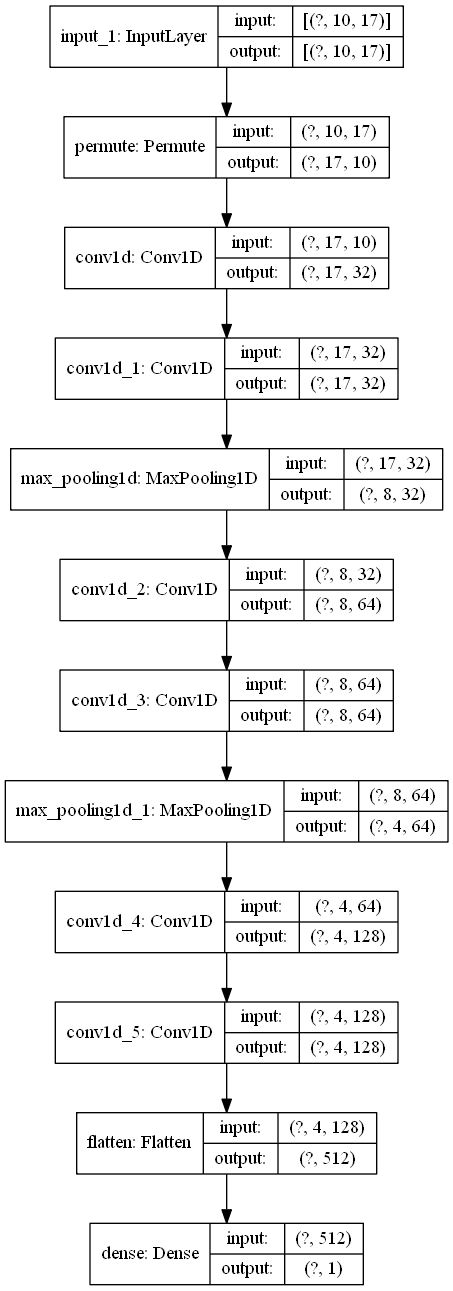

In [6]:
#training parametrs
loss='mae'#can be mae or mse
optimiser=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
metrics='mae'#can be mae or mse

model.compile(optimizer=optimiser, 
              loss=loss, 
              metrics=[metrics])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
#function for training early stopping when error<value
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True


In [8]:
optimiser=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimiser, 
              loss=loss, 
              metrics=[metrics])
model.summary()
callbacks = [
    EarlyStoppingByLossVal(monitor='val_loss', value=4.9, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint("checkpoint/checkpoint1.ckpt", monitor='val_loss', save_best_only=True, verbose=0),
]

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
history = model.fit(X_train_dataset_processed, 
                    Y_train_dataset_processed, 
                    validation_data=(X_val_dataset_processed, Y_val_dataset_processed),
                    epochs=300,
                    batch_size=200,
                    callbacks=callbacks
                    )
print(history.history.keys())
mse, mae = model.evaluate(X_val_dataset_processed, Y_val_dataset_processed, verbose=2)
print("mae mistake:", mae)
print("mistake mse:", mse)
mse, mae = model.evaluate(X_test_dataset_processed, Y_test_dataset_processed, verbose=2)
print("mae mistake:", mae)
print("mistake mse:", mse)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 95742 samples, validate on 5754 samples
Epoch 1/50
95742/95742 [==============================] - 345s 4ms/sample - loss: 11.3904 - mean_absolute_error: 11.3904 - val_loss: 9.1967 - val_mean_absolute_error: 9.1967
Epoch 2/50
95742/95742 [==============================] - 350s 4ms/sample - loss: 8.7708 - mean_absolute_error: 8.7708 - val_loss: 8.4790 - val_mean_absolute_error: 8.4790
Epoch 3/50
95742/95742 [==============================] - 353s 4ms/sample - loss: 8.0707 - mean_absolute_error: 8.0707 - val_loss: 8.0378 - val_mean_absolute_error: 8.0378
Epoch 4/50
95742/95742 [==============================] - 354s 4ms/sample - loss: 7.5964 - mean_absolute_error: 7.5964 - val_loss: 7.7058 - val_mean_absolute_error: 7.7058
Epoch 5/50
95742/95742 [==============================] - 352s 4ms/sample - loss: 7.1764 - mean_absolute_error: 7.1764 - val_loss: 7.1293 - val_mean_absolute_error: 7.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



95742/95742 [==============================] - 343s 4ms/sample - loss: 5.4401 - mean_absolute_error: 5.4401 - val_loss: 6.0742 - val_mean_absolute_error: 6.0742
Epoch 29/50
95742/95742 [==============================] - 350s 4ms/sample - loss: 5.3724 - mean_absolute_error: 5.3724 - val_loss: 5.9414 - val_mean_absolute_error: 5.9414
Epoch 30/50
95742/95742 [==============================] - 351s 4ms/sample - loss: 5.4722 - mean_absolute_error: 5.4722 - val_loss: 6.0606 - val_mean_absolute_error: 6.0606
Epoch 31/50
95742/95742 [==============================] - 356s 4ms/sample - loss: 5.4428 - mean_absolute_error: 5.4428 - val_loss: 6.1632 - val_mean_absolute_error: 6.1632
Epoch 32/50
95742/95742 [==============================] - 355s 4ms/sample - loss: 5.4883 - mean_absolute_error: 5.4883 - val_loss: 6.3272 - val_mean_absolute_error: 6.3272
Epoch 33/50
95742/95742 [==============================] - 353s 4ms/sample - loss: 5.5058 - mean_absolute_error: 5.5058 - val_loss: 6.1312 - val_me

In [12]:
optimiser=optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimiser, 
              loss=loss, 
              metrics=[metrics])
model.summary()
callbacks = [
    EarlyStoppingByLossVal(monitor='val_loss', value=4.8, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint("/content/gdrive/My Drive/superconductor/checkpoint/experiment1V6E9_32_01_2.3.ckpt", monitor='val_loss', save_best_only=True, verbose=0),
]

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
history = model.fit(X_train_dataset_processed, 
                    Y_train_dataset_processed, 
                    validation_data=(X_val_dataset_processed, Y_val_dataset_processed),
                    epochs=300,
                    batch_size=200,
                    callbacks=callbacks
                    )
print(history.history.keys())
mse, mae = model.evaluate(X_val_dataset_processed, Y_val_dataset_processed, verbose=2)
print("mae mistake:", mae)
print("mistake mse:", mse)
mse, mae = model.evaluate(X_test_dataset_processed, Y_test_dataset_processed, verbose=2)
print("mae mistake:", mae)
print("mistake mse:", mse)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 17)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10, 512)      1085440     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 10, 128)      74752       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10, 256)      787456      lstm[0][0]                       
______________________________________________________________________________________________

In [10]:
loss='mae'#loss calc for training    mae mse
#optimiser=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#optimiser=optimizers.RMSprop(lr=0.001, rho=0.9)
optimiser=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
metrics='mae'# output metrics

model.compile(optimizer=optimiser, 
              loss=loss, 
              metrics=[metrics])
model.summary()


plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
history = model.fit(X_train_dataset_processed, 
                    Y_train_dataset_processed, 
                    validation_data=(X_val_dataset_processed, Y_val_dataset_processed),
                    epochs=30,
                    batch_size=200
                    )
print(history.history.keys())
mse, mae = model.evaluate(X_val_dataset_processed, Y_val_dataset_processed, verbose=2)
print("mae mistake:", mae)
print("mistake mse:", mse)
mse, mae = model.evaluate(X_test_dataset_processed, Y_test_dataset_processed, verbose=2)
print("mae mistake:", mae)
print("mistake mse:", mse)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 17)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10, 512)      1085440     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 10, 128)      74752       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10, 256)      787456      lstm[0][0]                       
______________________________________________________________________________________________

In [0]:

model_json = model.to_json()
print(name)
json_file = open('/pretrained_networks/LSTM_R1' + ".json", "w")
#write structure
json_file.write(model_json)
json_file.close()
# write wtights
model.save_weights('/pretrained_networks/LSTM_R1'+".h5")
print("saving done")


In [14]:
#you can test it for different temperatures

#temperature diapason
min_val=90#minimum temperature
max_val=999#maximum temperature

X_test_0=[]
Y_test_0=[]
print("test")
for i in range(len(Y_test_dataset_processed)):
    if Y_test_dataset_processed[i]>min_val and Y_test_dataset_processed[i]<max_val:
        X_test_0.append(X_test_dataset_processed[i])
        Y_test_0.append(Y_test_dataset_processed[i])
X_test_0=np.asarray(X_test_0)
pred = model.predict(X_test_0)

mistake=0
a=[0,0,0,0,0]
for i in range(len(Y_test_0)):
    mistake=mistake+abs(pred[i][0]-Y_test_0[i])
    if abs(pred[i][0]-Y_test_0[i])<1:
        a[0]=a[0]+1
    if abs(pred[i][0]-Y_test_0[i])>1 and abs(pred[i][0]-Y_test_0[i])<5:
        a[1]=a[1]+1
    if abs(pred[i][0]-Y_test_0[i])>5 and abs(pred[i][0]-Y_test_0[i])<10:
        a[2]=a[2]+1
    if abs(pred[i][0]-Y_test_0[i])>10 and abs(pred[i][0]-Y_test_0[i])<100:
        a[3]=a[3]+1
mistake=mistake/len(Y_test_0)
print("MAE for these temperatures")
print(mistake)

print((a[0]+a[1]+a[2])/((a[0]+a[1]+a[2]+a[3])))
print("percent of error smaller than 1 degree")
print((a[0])/((a[0]+a[1]+a[2]+a[3])))
print("percent of error smaller than 5 degree")
print((a[1])/((a[0]+a[1]+a[2]+a[3])))
print("percent of error smaller than 10 degree")
print((a[2])/((a[0]+a[1]+a[2]+a[3])))

print("show all results")
for i in range(len(Y_test_0)):
    print("preficted="+str(pred[i][0])+" real="+str(Y_test_0[i]))
X_test_0=[]
Y_test_0=[]




val
5000
4.904475536906529
[2375, 1891, 695, 793, 0]
0.862182829336114
<1
0.4127563434132777
<5
0.3286409454292666
<10
0.1207855404935697
test
5000
4.0218787142615176
[2576, 1938, 634, 634, 0]
0.8903493600830162
<1
0.44552058111380144
<5
0.33517813905223104
<10
0.10965063991698375
